In [1]:

# Auto-reload external modules when their source changes
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import src.train as train
import src.models as models
import utils.helpers as helpers
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Path variables
BASE_PATH = "src/inputs/"
TRAIN_PATH = BASE_PATH + "train.csv"
TEST_PATH = BASE_PATH + "test.csv"
train_jpg = glob(BASE_PATH + "train/*.jpg")
test_jpg = glob(BASE_PATH + "test/*.jpg")



c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Data Loading and EDA
2. Models Application  
> 
 - 2.1)   Vision Transformer (images+metadata)  
 - 2.2)   Swin Transformer (images)  

In [2]:
# to set the seeds for reproducibility
helpers.set_seeds()

Loading train and test csv files

In [3]:
train_df = pd.read_csv(BASE_PATH + "train.csv")
test_df =  pd.read_csv(BASE_PATH + "test.csv")


In [4]:
print("train shape:",train_df.shape)
print("test shape",test_df.shape)


train shape: (9912, 14)
test shape (8, 13)


In [5]:
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [6]:
test_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  
0          1      1        0      0          1     0     1  
1          0      1        1      0          0     0     0  
2          1      1        1      0          1     1     1  
3          0      0        0      0          0     1     0  
4          1      0        1      0          1     1     0

The train.csv and test.csv files contain metadata for photos in the training set and test set, respectively. Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features:

Focus - Pet stands out against uncluttered background, not too close / far.  
Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.  
Face - Decently clear face, facing front or near-front.  
Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).  
Action - Pet in the middle of an action (e.g., jumping).  
Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.  
Group - More than 1 pet in the photo.  
Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).  
Human - Human in the photo.  
Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.  
Info - Custom-added text or labels (i.e. pet name, description).  
Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.  

In [7]:
print("Null Values: ",train_df.isnull().sum())
print("Duplicate Values: ",train_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64
Duplicate Values:  0


In [8]:
print("Null Values: ",test_df.isnull().sum())
print("Duplicate Values: ",test_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
dtype: int64
Duplicate Values:  0


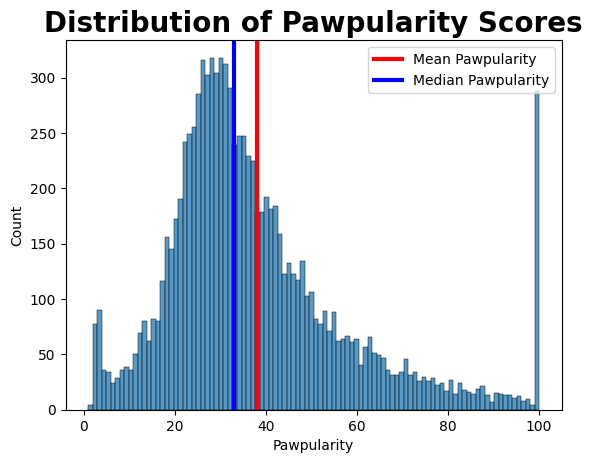

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444
There are 100 unique values of Pawpularity score


In [9]:
#To check the distribution of Pawpularity Scores

helpers.plotDistribution(train_df)

print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")


> From the distribution graph above, we can see that pets with Pawpularity score 20 to 40 are more, Also there is a high peak at 100 score, but before that most of the pets have the score from around ~60 - ~90 .  

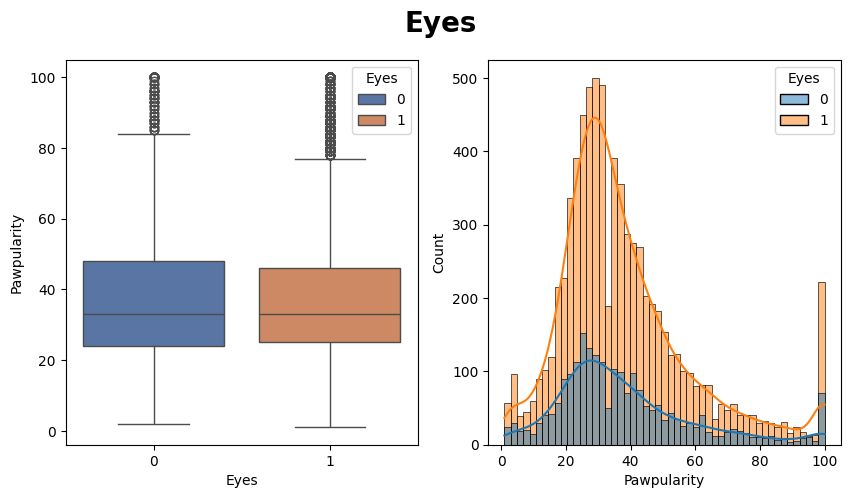

In [10]:
#showing one feature with the Pawpularity
helpers.plotDistributionAcrossEachFeature(["Eyes"],train_df)

> For the single feature like "Eye", both categories "0", "1" are similar as shown in the box plot, However we can see that those with high pawpularity are mostly the pets facing front or near-front, with at least 1 eye / pupil decently clear. 

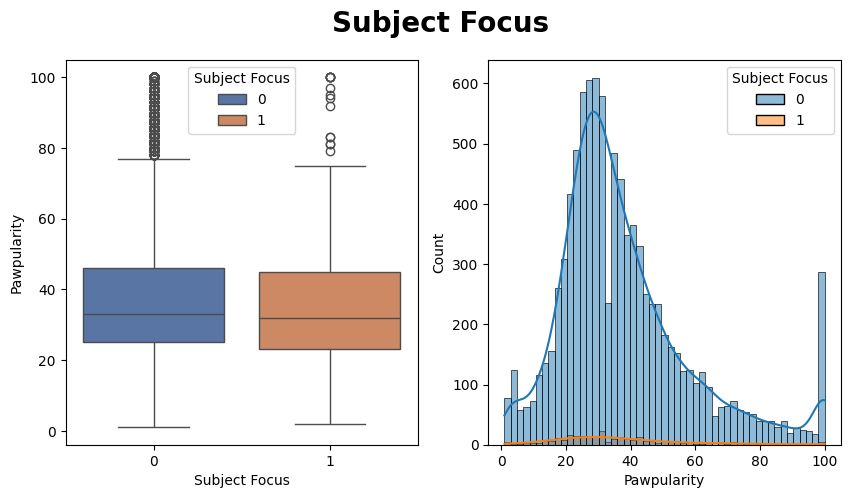

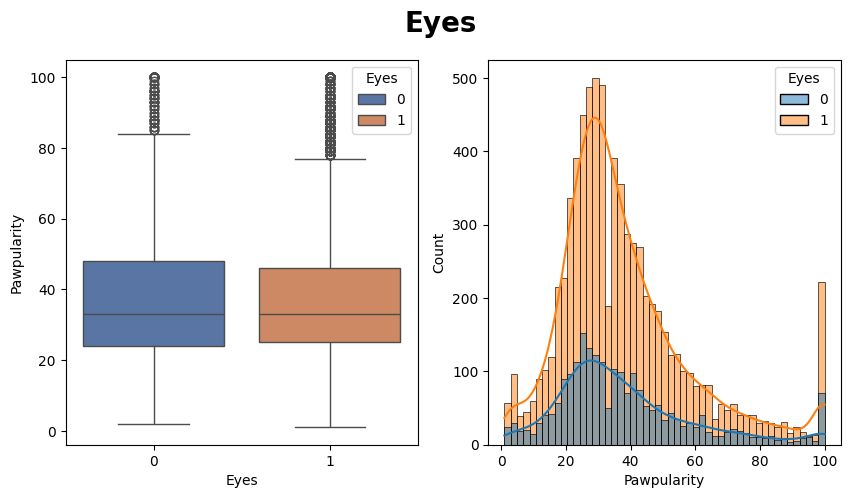

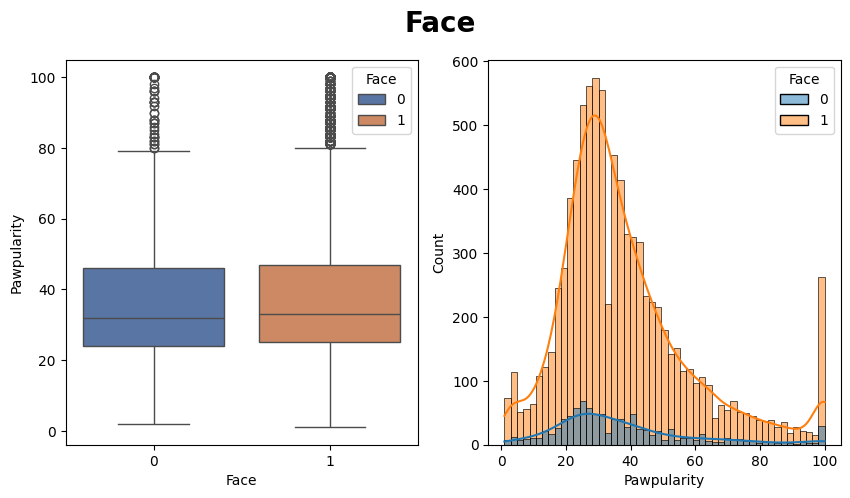

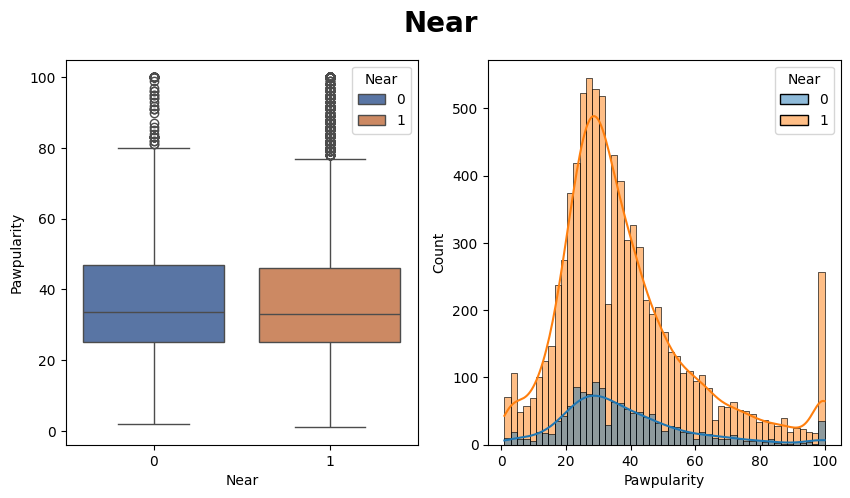

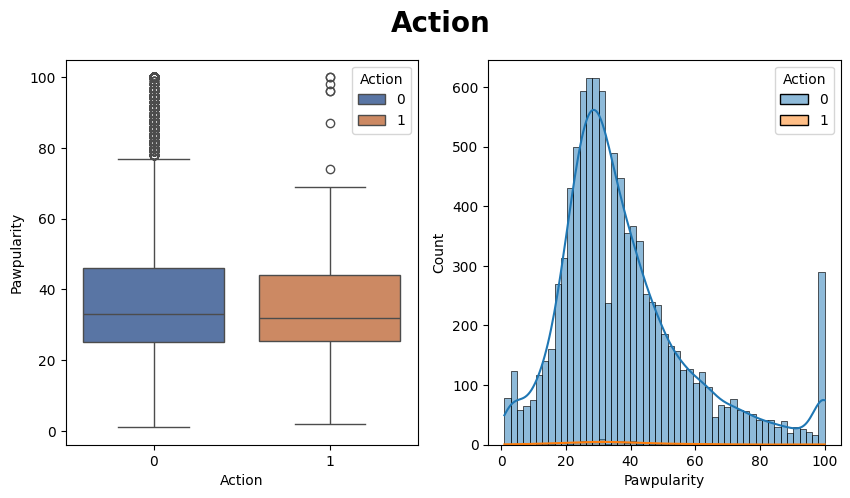

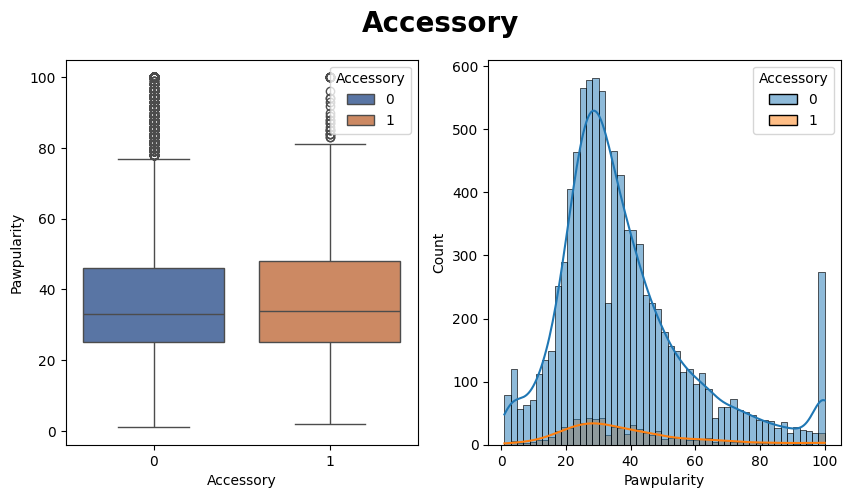

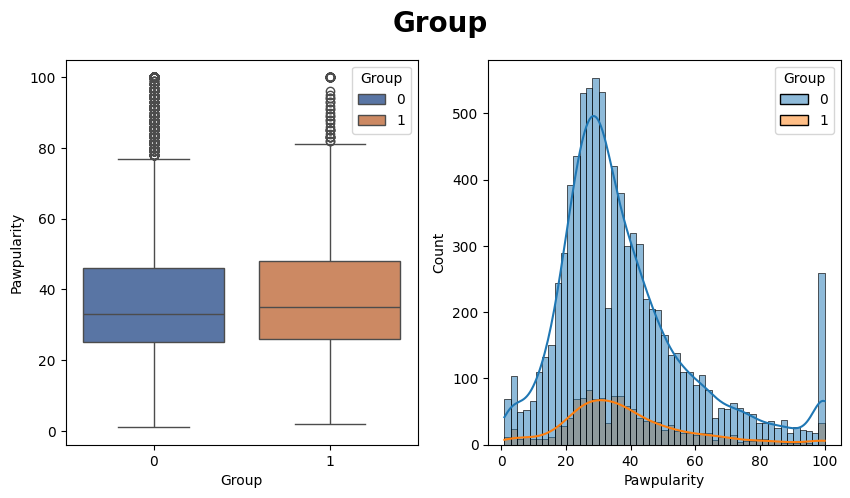

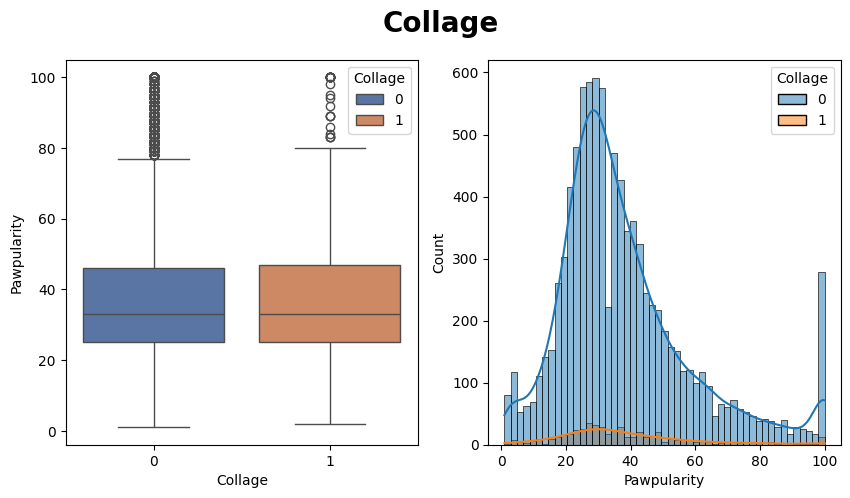

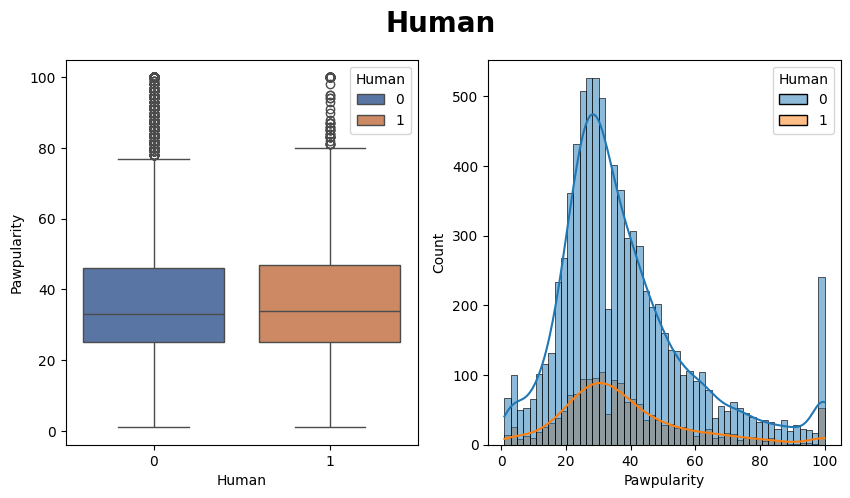

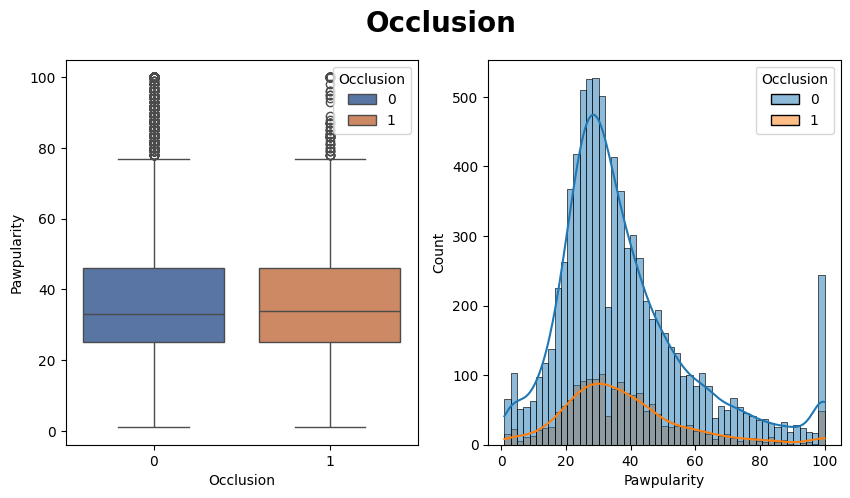

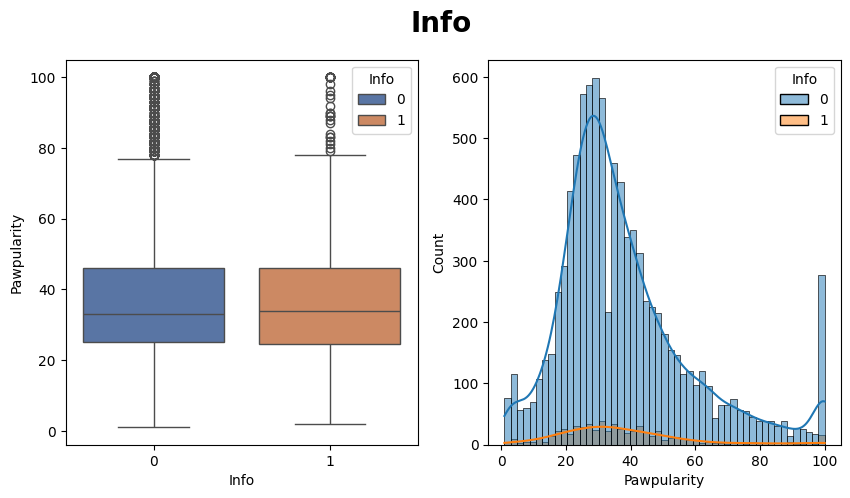

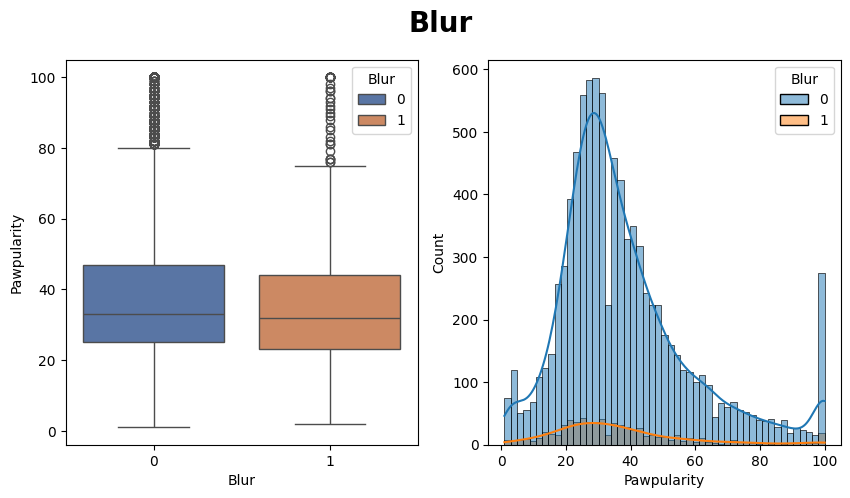

In [11]:
# Let's all features
feature_variables = train_df.columns.values.tolist()[1:-1] #to exclude id and Pawpularity
helpers.plotDistributionAcrossEachFeature(feature_variables,train_df)

### Week-1,Feedback 1
(Assignment: Add the correlation matrix and VIF calculation code to your notebook, and make sure to include explanatory comments.)

> Looking at the above distribtions, we can see the usually the pets with less blur, no object or human inclusion, without frame and tools, near are labelled with high score, Now let's if there is any correlation between the feature and pawpularity as well as multicollinearity which describe if the features are correlated with each other (we can use correlation matrix and VIF- Variance Inflation Factor )

1. Correlation Matrix shows the how two variable are related/affected by each other
2. VIF describes how one variable is related with all other input features

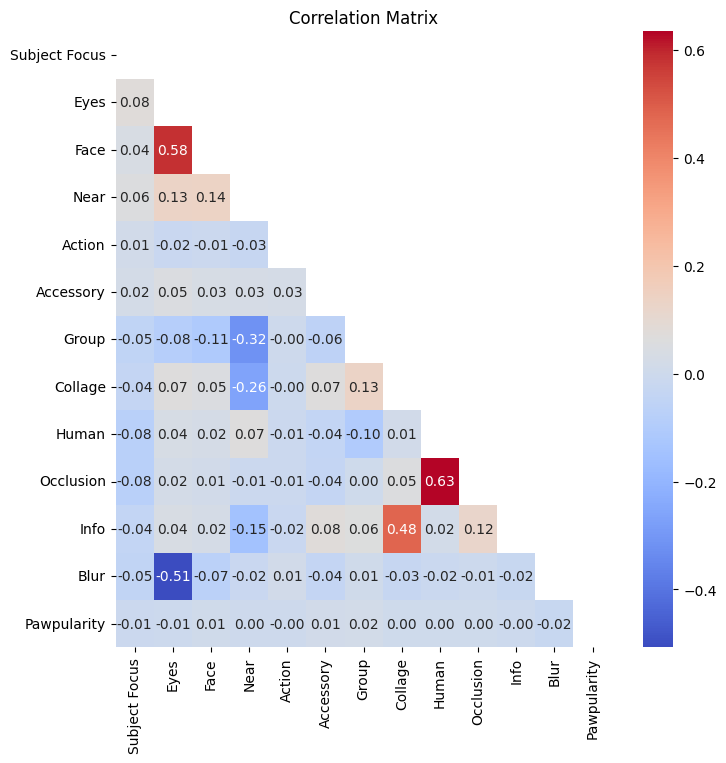

Subject Focus   -0.009853
Eyes            -0.006686
Face             0.008018
Near             0.001001
Action          -0.001373
Accessory        0.013287
Group            0.016469
Collage          0.001732
Human            0.003983
Occlusion        0.001979
Info            -0.004735
Blur            -0.023540
Name: Pawpularity, dtype: float64


In [12]:

helpers.plotCorrelationMatrix(train_df)


> Here we can see that there is not much significance correlation between the feature and pawpuarlity, However there is some correlation between the input features like Face and Eyes, Human and Occlusion.

>   The first between Occlusion and Human (Humans can hide part of the animal)
The second between Face and Eyes which means If the face is clear and front-facing, chances are both eyes are also visible and clear. 

In [13]:
helpers.calculateVIF(train_df.loc[:, ~train_df.columns.isin(["Id", "Pawpularity"])])

feature        VIF
2            Face  13.715668
1            Eyes  10.118170
3            Near   5.762924
9       Occlusion   2.073562
8           Human   2.064939
11           Blur   1.595109
7         Collage   1.452023
10           Info   1.412621
6           Group   1.163850
5       Accessory   1.090942
0   Subject Focus   1.048292
4          Action   1.010174

> #### Here we can see that Face and Eyes are high correclated, which signal to use some regularization when we apply model on meta data

### Now let's explore images

In [14]:
id_stem = Path(train_jpg[0]).stem
print('Original: ', train_jpg[0])
print('After: ', id_stem)


Original:  src/inputs/train\0007de18844b0dbbb5e1f607da0606e0.jpg
After:  0007de18844b0dbbb5e1f607da0606e0


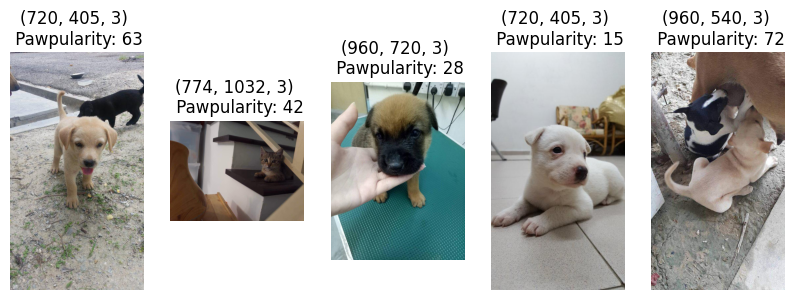

In [15]:
#let's see first 5 images
helpers.showPicture(5, train_jpg, train_df)

In [16]:
#Let's see the lowest and highest score images
print(train_df["Pawpularity"].max())
print(train_df["Pawpularity"].min())


100
1


In [17]:
train_df_max_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].max(),"Id"].iloc[0]
train_df_min_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].min(),"Id"].iloc[0]

In [18]:
filtered_jpg = [p for p in train_jpg if Path(p).stem in [train_df_max_id,train_df_min_id]]

##### let's check the high Pawpularity and low Pawpularity images

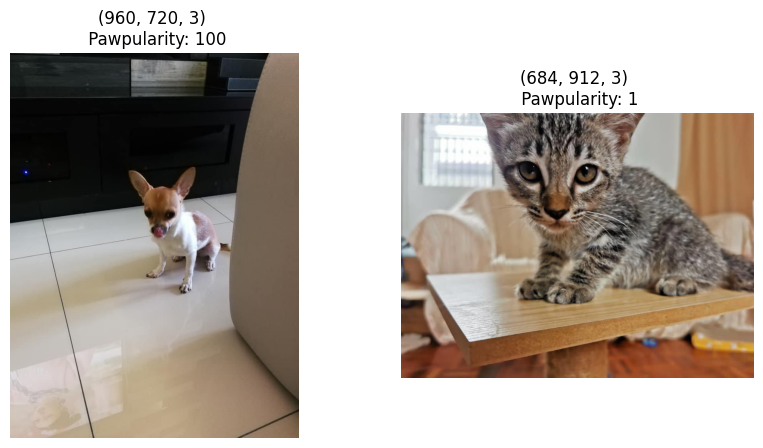

In [19]:
helpers.showPicture(2, filtered_jpg, train_df)

In [20]:
train_df

Id  Subject Focus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0              0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db              0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246              0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2              0     0     0     1   
...                                ...            ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57              0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45              0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20              0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a              0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  
0              63  
1              42  
2              28  
3              15  
4              72  
...           ...  
9907           15  
9908           70  
9909           20  
9910           20  
9911           30  

[9912 rows x 14 columns]

<br>



### Week-1, Feedback 2
 (Add the code for computing image features(Brightness, Contrast, saturation, sharpness, edge density, resolution, aspect ration) and visualizing their relationship with the target to your notebook, and include explanatory comments)

> Now we will check some other pattern from image and will their correlation with target pawpularity 

In [21]:
len(train_df)

9912

In [22]:
# adding the image path to the metadata table
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')
# this function will calculate edges, brightness,contrast etc for each image 
features_list = helpers.extractFeature(train_df)
print(len(features_list))


9912


In [23]:
img_features_df = pd.DataFrame(features_list)

# Merging with metadata table
merged_df = train_df.merge(img_features_df, on='Id')

print(len(merged_df))

9912


In [24]:
merged_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  ...  Pawpularity  \
0          0      1        0      0  ...           63   
1          0      0        0      0  ...           42   
2          0      0        0      1  ...           28   
3          0      0        0      0  ...           15   
4          0      1        0      0  ...           72   

                                                path  brightness   contrast  \
0  src/inputs/train/0007de18844b0dbbb5e1f607da060...  149.636001  47.226252   
1  src/inputs/train/0009c66b9439883ba2750fb825e1d...   95.569681  55.386129   
2  src/inputs/train/0013fd999caf9a3efe1352ca1b0d9...  117.427021  58.077102   
3  src/inputs/train/0018df346ac9c1d8413cfcc888ca8...  156.972733  50.189218   
4  src/inputs/train/001dc955e10590d3ca4673f034fee...  129.294448  54.795065   

   saturation    sharpness  edge_density  width  height  aspect_ratio  
0   26.977051  4434.230369      0.221547    405     720      0.562500  
1   65.260191    28.845254      0.009222   1032     774      1.333333  
2  100.025308   151.709166      0.037694    720     960      0.750000  
3   27.387541   418.406313      0.028875    405     720      0.562500  
4   35.232224  2241.652292      0.156723    540     960      0.562500  

[5 rows x 23 columns]

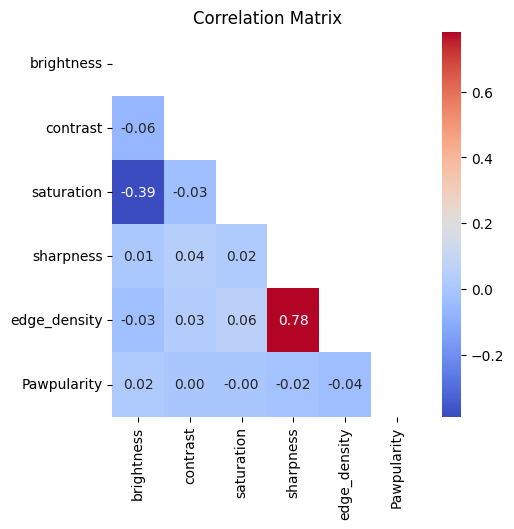

brightness      0.017841
contrast        0.001438
saturation     -0.003212
sharpness      -0.020849
edge_density   -0.036936
Name: Pawpularity, dtype: float64


In [25]:

added_features = ['Id','brightness', 'contrast', 'saturation', 'sharpness', 'edge_density','Pawpularity']
helpers.plotCorrelationMatrix(merged_df[added_features],figsize=(5,5))

> None of these individual image features have a strong  correlation with Pawpularity. 

# Models Improvement

In [26]:
#path column added to access the images path
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1     1       0          0      0        0      0   
1              0     1     1     0       0          0      0        1      0   
2              0     1     1     1       0          1      0        0      0   
3              0     0     1     1       0          0      1        0      0   
4              0     1     1     1       0          0      1        0      0   

   Occlusion  Info  Blur  Pawpularity  \
0          0     0     0           40   
1          0     0     0           64   
2          0     0     0           26   
3          0     0     0           73   
4          0     0     0           39   

                                                path  
0  src/inputs/train/48d53aeabee4f92f77eee3a323343...  
1  src/inputs/train/b60e82fd313066b801fa4431d1ce4...  
2  src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...  
3  src/inputs/train/263879abce68de4af02ef5f7ef873...  
4  src/inputs/train/4ea0587a137c7983ca92851b6cb36...

In [27]:
#normalizing 
train_df['norm_score'] = train_df['Pawpularity']/100
train_df.head()

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1     1       0          0      0        0      0   
1              0     1     1     0       0          0      0        1      0   
2              0     1     1     1       0          1      0        0      0   
3              0     0     1     1       0          0      1        0      0   
4              0     1     1     1       0          0      1        0      0   

   Occlusion  Info  Blur  Pawpularity  \
0          0     0     0           40   
1          0     0     0           64   
2          0     0     0           26   
3          0     0     0           73   
4          0     0     0           39   

                                                path  norm_score  
0  src/inputs/train/48d53aeabee4f92f77eee3a323343...        0.40  
1  src/inputs/train/b60e82fd313066b801fa4431d1ce4...        0.64  
2  src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...        0.26  
3  src/inputs/train/263879abce68de4af02ef5f7ef873...        0.73  
4  src/inputs/train/4ea0587a137c7983ca92851b6cb36...        0.39

<Axes: >

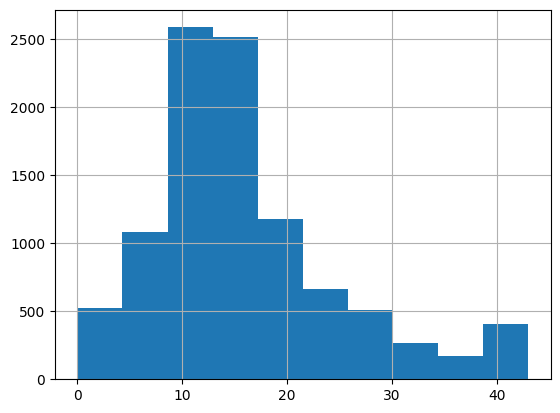

In [28]:
import numpy as np
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<Axes: xlabel='fold'>

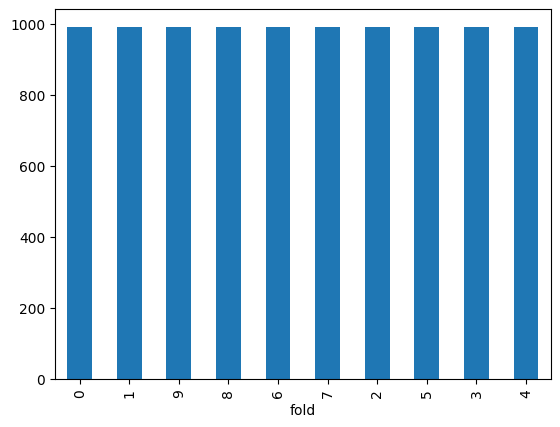

In [29]:

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
seed = 999
train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [30]:
import torchtext.vocab as vocab

In [31]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_model = load_glove_model(BASE_PATH+"glove.6B.50d.txt")

Loading Glove Model
400000 words loaded!


In [32]:
import torch
metadata_glove = torch.zeros(12,50).cuda()
metadata_glove[0] = torch.tensor(glove_model['focus'])
metadata_glove[1] = torch.tensor(glove_model['eyes'])
metadata_glove[2] = torch.tensor(glove_model['face'])
metadata_glove[3] = torch.tensor(glove_model['near'])
metadata_glove[4] = torch.tensor(glove_model['action'])
metadata_glove[5] = torch.tensor(glove_model['accessory'])
metadata_glove[6] = torch.tensor(glove_model['group'])
metadata_glove[7] = torch.tensor(glove_model['collage'])
metadata_glove[8] = torch.tensor(glove_model['human'])
metadata_glove[9] = torch.tensor(glove_model['occlusion'])
metadata_glove[10] = torch.tensor(glove_model['info'])
metadata_glove[11] = torch.tensor(glove_model['blur'])

In [33]:
glove_model

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [34]:

# Show 5 sample words and their vectors
for i, (word, vector) in enumerate(glove_model.items()):
    print(f"{word}: {vector[:10]}...")  # Show only first 10 dimensions 
    if i == 4:
        break


the: [ 0.418       0.24968    -0.41242     0.1217      0.34527    -0.044457
 -0.49688    -0.17862    -0.00066023 -0.6566    ]...
,: [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938 ]...
.: [ 0.15164  0.30177 -0.16763  0.17684  0.31719  0.33973 -0.43478 -0.31086
 -0.44999 -0.29486]...
of: [ 0.70853  0.57088 -0.4716   0.18048  0.54449  0.72603  0.18157 -0.52393
  0.10381 -0.17566]...
to: [ 0.68047  -0.039263  0.30186  -0.17792   0.42962   0.032246 -0.41376
  0.13228  -0.29847  -0.085253]...


In [35]:
train_df

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  \
0                 0     1     1     1       0          0      0        0   
1                 0     1     1     0       0          0      0        1   
2                 0     1     1     1       0          1      0        0   
3                 0     0     1     1       0          0      1        0   
4                 0     1     1     1       0          0      1        0   
...             ...   ...   ...   ...     ...        ...    ...      ...   
9907              0     1     1     1       0          0      0        0   
9908              0     1     1     1       0          0      0        0   
9909              0     1     1     1       0          0      0        0   
9910              0     1     1     1       0          0      0        0   
9911              0     1     1     1       0          0      1        0   

      Human  Occlusion  Info  Blur  Pawpularity  \
0         0          0     0     0           40   
1         0          0     0     0           64   
2         0          0     0     0           26   
3         0          0     0     0           73   
4         0          0     0     0           39   
...     ...        ...   ...   ...          ...   
9907      1          1     0     0           31   
9908      0          0     0     0           25   
9909      0          0     0     0           60   
9910      1          0     0     0           66   
9911      0          0     0     0           27   

                                                   path  norm_score  bins  \
0     src/inputs/train/48d53aeabee4f92f77eee3a323343...        0.40    17   
1     src/inputs/train/b60e82fd313066b801fa4431d1ce4...        0.64    27   
2     src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...        0.26    11   
3     src/inputs/train/263879abce68de4af02ef5f7ef873...        0.73    31   
4     src/inputs/train/4ea0587a137c7983ca92851b6cb36...        0.39    16   
...                                                 ...         ...   ...   
9907  src/inputs/train/94773ee6f04891c99bc4d37e8f20f...        0.31    13   
9908  src/inputs/train/85e7146eeb13644b1bac74b684ccf...        0.25    10   
9909  src/inputs/train/8afb263d779be24c94f01046e5ec3...        0.60    26   
9910  src/inputs/train/15bda3335526d2ab18834c65f93ad...        0.66    28   
9911  src/inputs/train/bb263c3f1605cd5688a6fd1626f62...        0.27    11   

      fold  
0        8  
1        9  
2        7  
3        1  
4        1  
...    ...  
9907     5  
9908     0  
9909     2  
9910     9  
9911     9  

[9912 rows x 17 columns]

In [36]:

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import gc

In [37]:

USE_384 = False  
IMAGE_SIZE = 384 if USE_384 else 224
BATCH_SIZE = 20 if USE_384 else 40  # Reduce batch size for 384
MODEL_NAME = 'swin_large_patch4_window12_384' if USE_384 else 'swin_large_patch4_window7_224'

SEED = 999
N_FOLDS = 4
EPOCHS_META = 10
EPOCHS_IMAGE = 5
LR_IMAGE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Image size: {IMAGE_SIZE}, Batch size: {BATCH_SIZE}, Model: {MODEL_NAME}")


Using device: cuda
Image size: 224, Batch size: 40, Model: swin_large_patch4_window7_224


In [38]:
def petfinder_rmse(input, target):
    return 100 * torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [39]:
# ============================================================================
# Datasets
# ============================================================================
class MetadataDataset(Dataset):
    def __init__(self, df):
        self.metadata = df[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                            'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 
                            'Info', 'Blur']].values.astype(np.float32)
        self.targets = (df['Pawpularity'].values / 100.0).astype(np.float32)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.metadata[idx]), torch.tensor(self.targets[idx])

class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df['path'].values
        self.targets = (df['Pawpularity'].values / 100.0).astype(np.float32)
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, torch.tensor(self.targets[idx])


In [40]:
# Augmentations 
def get_train_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [41]:
# ============================================================================
# Metadata Model 
# ============================================================================
class PawpularModel_meta(nn.Module):
    def __init__(self, reduction_dim=5, batch_size=BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.reduce_d = nn.Linear(50, reduction_dim)
        self.meta_order1 = nn.Linear(432 + 60, 100)
        self.meta_order2 = nn.Linear(100, 10)
        self.meta_order3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features):
        actual_batch_size = features.size(0)
        
        # Create embeddings (paper's approach)
        embed = torch.zeros(actual_batch_size, *metadata_glove.shape).to(features.device)
        for idx, eve_feature in enumerate(features):
            embed[idx] = (eve_feature * metadata_glove.T).T
        
        # Reduce dimension
        embed_reduce = self.reduce_d(embed)
        
        # Normalize
        embed_norm = torch.norm(embed_reduce, dim=2, keepdim=True).clamp(min=1e-8)
        embed_reduce = embed_reduce / embed_norm
        
        # High-order interactions
        dot_result = torch.bmm(embed_reduce, embed_reduce.permute(0, 2, 1)).reshape(actual_batch_size, -1)
        dot_tanh = torch.tanh(dot_result)
        dot_relu = F.relu(dot_result)
        dot_sig = torch.sigmoid(dot_result)
        
        # Concatenate
        hig_order = torch.cat([dot_tanh, dot_relu, dot_sig], 1)
        all_order = torch.cat([embed_reduce.reshape(actual_batch_size, -1), hig_order], 1)
        
        # MLP
        out1 = self.meta_order1(self.dropout(all_order))
        out2 = self.meta_order2(self.dropout(out1))
        out3 = self.meta_order3(self.dropout(out2))
        
        return out3

In [42]:
# ============================================================================
#  Image Model 
# ============================================================================
class PawpularModel_image(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=1)
        
    def forward(self, x):
        return self.model(x)

In [43]:
# ============================================================================
# Training functions
# ============================================================================
def train_meta_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training Meta')
    for metadata, targets in pbar:
        metadata = metadata.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(metadata)
        loss = petfinder_rmse(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return running_loss / len(loader)


In [44]:
def validate_meta(model, loader):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for metadata, targets in tqdm(loader, desc='Validating Meta'):
            metadata = metadata.to(DEVICE)
            targets = targets.to(DEVICE)
            
            outputs = model(metadata)
            loss = petfinder_rmse(outputs, targets)
            running_loss += loss.item()
    
    return running_loss / len(loader)

In [45]:
def train_image_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training Image')
    for images, targets in pbar:
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.binary_cross_entropy_with_logits(outputs.flatten(), targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Calculate RMSE for display
        rmse = petfinder_rmse(outputs, targets)
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'rmse': f'{rmse.item():.4f}'})
    
    return running_loss / len(loader)


In [46]:
def validate_image(model, loader):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Validating Image'):
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            
            outputs = model(images)
            loss = petfinder_rmse(outputs, targets)
            running_loss += loss.item()
    
    return running_loss / len(loader)

In [49]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.isotonic import IsotonicRegression
from pathlib import Path
import gc

# Helper functions needed for grid search
def calculate_ensemble_rmse(meta_preds, image_preds, targets, meta_weight, image_weight):
    """Calculate TRUE ensemble RMSE by combining predictions"""
    ensemble_preds = meta_preds * meta_weight + image_preds * image_weight
    rmse = 100 * torch.sqrt(F.mse_loss(ensemble_preds, targets))
    return rmse.item()

def grid_search_optimal(meta_preds, image_preds, targets):
    """Find optimal weights by trying all combinations with finer steps"""
    best_rmse = float('inf')
    best_meta_w = 0.5
    
    for meta_w in np.arange(0.0, 1.01, 0.01):
        image_w = 1.0 - meta_w
        ensemble = meta_preds * meta_w + image_preds * image_w
        rmse = 100 * torch.sqrt(F.mse_loss(ensemble, targets)).item()
        if rmse < best_rmse:
            best_rmse = rmse
            best_meta_w = meta_w
    
    return best_meta_w, 1.0 - best_meta_w, best_rmse

# ============================================================================
# Main training loop with true validation RMSE
# ============================================================================
def train_fold(fold, train_df, val_df, save_dir='models_train'):
    Path(save_dir).mkdir(exist_ok=True)
    
    print(f'\n{"="*50}')
    print(f'Fold {fold+1} results')
    print(f'{"="*50}')
    
    # ========== Train Metadata Model ==========
    print('\n--- Training Metadata Model ---')
    
    meta_train_dataset = MetadataDataset(train_df)
    meta_val_dataset = MetadataDataset(val_df)
    
    meta_train_loader = DataLoader(
        meta_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True
    )
    meta_val_loader = DataLoader(
        meta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    meta_model = PawpularModel_meta(batch_size=BATCH_SIZE).to(DEVICE)
    meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-3)
    
    best_meta_rmse = float('inf')
    patience_counter = 0
    
    for epoch in range(1, EPOCHS_META + 1):
        train_loss = train_meta_epoch(meta_model, meta_train_loader, meta_optimizer)
        val_rmse = validate_meta(meta_model, meta_val_loader)
        
        print(f'Epoch {epoch}/{EPOCHS_META} - Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        
        if val_rmse < best_meta_rmse:
            best_meta_rmse = val_rmse
            patience_counter = 0
            torch.save(meta_model.state_dict(), f'{save_dir}/meta_model_fold_{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= 2:
                print(f'Early stopping triggered at epoch {epoch}')
                break
    
    val_rmse_meta = best_meta_rmse
    print(f'Best Meta RMSE: {val_rmse_meta:.4f}')
    
    # ==================== Meta predictions for validation ====================
    meta_model.eval()
    preds_meta_val = []
    targets_val = []
    with torch.no_grad():
        for metadata, target in meta_val_loader:
            metadata = metadata.to(DEVICE)
            target = target.to(DEVICE)
            output = meta_model(metadata)
            preds_meta_val.append(torch.sigmoid(output.flatten()))  # same as petfinder_rmse
            targets_val.append(target)
    preds_meta_val = torch.cat(preds_meta_val)
    targets_val = torch.cat(targets_val)
    # ============================================================================

    # Cleanup
    del meta_model, meta_optimizer
    del meta_train_loader, meta_val_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    print('meta process is done!')
    
    # ========== Train Image Model ==========
    print('\n--- Training Image Model ---')
    
    image_train_dataset = ImageDataset(train_df, transform=get_train_transforms())
    image_val_dataset = ImageDataset(val_df, transform=get_valid_transforms())
    
    image_train_loader = DataLoader(
        image_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True
    )
    image_val_loader = DataLoader(
        image_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    image_model = PawpularModel_image().to(DEVICE)
    image_optimizer = torch.optim.AdamW(image_model.parameters(), lr=LR_IMAGE, weight_decay=1e-6)
    
    best_image_rmse = float('inf')
    patience_counter = 0
    
    for epoch in range(1, EPOCHS_IMAGE + 1):
        print(f"\nEpoch {epoch}/{EPOCHS_IMAGE}")
        train_loss = train_image_epoch(image_model, image_train_loader, image_optimizer)
        val_rmse = validate_image(image_model, image_val_loader)
        
        print(f'Epoch {epoch}/{EPOCHS_IMAGE} - Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        
        if val_rmse < best_image_rmse:
            best_image_rmse = val_rmse
            patience_counter = 0
            torch.save(image_model.state_dict(), f'{save_dir}/image_model_fold_{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= 2:
                print(f'Early stopping triggered at epoch {epoch}')
                break
    
    val_rmse_pic = best_image_rmse
    print(f'Best Image RMSE: {val_rmse_pic:.4f}')
    
    # ==================== Image predictions for validation ====================
    image_model.eval()
    preds_pic_val = []
    with torch.no_grad():
        for images, _ in image_val_loader:
            images = images.to(DEVICE)
            output = image_model(images)
            preds_pic_val.append(torch.sigmoid(output.flatten()))
    preds_pic_val = torch.cat(preds_pic_val)
    # ============================================================================

    # Cleanup
    del image_model, image_optimizer
    del image_train_loader, image_val_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    print('pic process is done!')
    
    # ========== Calibrate Predictions ==========
    print('Calibrating predictions...')
    cal_meta = IsotonicRegression(out_of_bounds='clip').fit(preds_meta_val.cpu().numpy().reshape(-1,1), targets_val.cpu().numpy())
    cal_image = IsotonicRegression(out_of_bounds='clip').fit(preds_pic_val.cpu().numpy().reshape(-1,1), targets_val.cpu().numpy())
    preds_meta_val_cal = torch.tensor(cal_meta.predict(preds_meta_val.cpu().numpy().reshape(-1,1)))
    preds_pic_val_cal = torch.tensor(cal_image.predict(preds_pic_val.cpu().numpy().reshape(-1,1)))
    
    # Compute calibrated RMSEs
    meta_rmse_cal = 100 * torch.sqrt(F.mse_loss(preds_meta_val_cal, targets_val.cpu())).item()
    pic_rmse_cal = 100 * torch.sqrt(F.mse_loss(preds_pic_val_cal, targets_val.cpu())).item()
    
    # ========== Compute True Ensemble RMSE with Grid Search ==========
    print('Searching for optimal weights...')
    meta_weight, pic_weight, true_ensemble_rmse = grid_search_optimal(preds_meta_val_cal, preds_pic_val_cal, targets_val.cpu())
    
    print(f'Best Meta RMSE (raw): {val_rmse_meta:.4f}')
    print(f'Best Meta RMSE (cal): {meta_rmse_cal:.4f}')
    print(f'Best Image RMSE (raw): {val_rmse_pic:.4f}')
    print(f'Best Image RMSE (cal): {pic_rmse_cal:.4f}')
    print(f'Optimal Meta Weight: {meta_weight:.4f}')
    print(f'Optimal Image Weight: {pic_weight:.4f}')
    print(f'True Validation Ensemble RMSE (Grid Search): {true_ensemble_rmse:.4f}')
    
    torch.save({
        'fold': fold,
        'val_rmse_meta': float(val_rmse_meta),
        'val_rmse_pic': float(val_rmse_pic),
        'val_rmse_meta_cal': float(meta_rmse_cal),
        'val_rmse_pic_cal': float(pic_rmse_cal),
        'meta_weight': float(meta_weight),
        'pic_weight': float(pic_weight),
        'true_ensemble_rmse': round(float(true_ensemble_rmse), 4)
    }, f'{save_dir}/fold_{fold}_results.pth')
        
    return true_ensemble_rmse

In [ ]:
# ============================================================================
# Training loop
# ============================================================================
import time

results = []
start = time.time()
for fold in range(N_FOLDS):
    train_fold_df = train_df[train_df['fold'] != fold].reset_index(drop=True)
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    
    ensemble_rmse = train_fold(fold, train_fold_df, val_fold_df)
    
    results.append({
        'fold': fold,
        'validation_rmse': ensemble_rmse
    })

# Summary
print(f'\n{"="*50}')
total_time = time.time() - start
total_hours = int(total_time // 3600)
total_minutes = int((total_time % 3600) // 60)
print('Training Complete!')
print(f'Total training time: {total_hours}h {total_minutes}m')

for result in results:
    print(f"Fold {result['fold']}: RMSE = {result['validation_rmse']:.4f}")

avg_rmse = np.mean([r['validation_rmse'] for r in results])
print(f'\nFinal Average Validation RMSE: {avg_rmse:.4f}')

results.append({
    'fold': 'average',
    'validation_rmse': avg_rmse
})


Fold 1 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 609.30it/s]


Epoch 1/10 - Train Loss: 21.7256, Val RMSE: 20.5804


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 610.91it/s]


Epoch 2/10 - Train Loss: 20.9286, Val RMSE: 20.5140


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 582.49it/s]


Epoch 3/10 - Train Loss: 20.5806, Val RMSE: 20.4984


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 611.52it/s]


Epoch 4/10 - Train Loss: 20.4916, Val RMSE: 20.5068


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 618.65it/s]


Epoch 5/10 - Train Loss: 20.4532, Val RMSE: 20.4979


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 559.03it/s]


Epoch 6/10 - Train Loss: 20.3703, Val RMSE: 20.5011


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 565.51it/s]


Epoch 7/10 - Train Loss: 20.4007, Val RMSE: 20.5023
Early stopping triggered at epoch 7
Best Meta RMSE: 20.4979
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Epoch 1/5 - Train Loss: 0.6538, Val RMSE: 18.0479

Epoch 2/5


Validating Image: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Epoch 2/5 - Train Loss: 0.6429, Val RMSE: 18.1383

Epoch 3/5


Validating Image: 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


Epoch 3/5 - Train Loss: 0.6377, Val RMSE: 18.1963
Early stopping triggered at epoch 3
Best Image RMSE: 18.0479
pic process is done!
Calibrating predictions...
Searching for optimal weights...
Best Meta RMSE (raw): 20.4979
Best Meta RMSE (cal): 20.5405
Best Image RMSE (raw): 18.0479
Best Image RMSE (cal): 17.5894
Optimal Meta Weight: 0.0100
Optimal Image Weight: 0.9900
True Validation Ensemble RMSE (Grid Search): 17.5888

Fold 2 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 446.97it/s]


Epoch 1/10 - Train Loss: 21.5250, Val RMSE: 20.5129


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 550.58it/s]


Epoch 2/10 - Train Loss: 20.7531, Val RMSE: 20.4659


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 570.10it/s]


Epoch 3/10 - Train Loss: 20.5502, Val RMSE: 20.4756


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 564.81it/s]


Epoch 4/10 - Train Loss: 20.5020, Val RMSE: 20.4461


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 544.04it/s]


Epoch 5/10 - Train Loss: 20.4220, Val RMSE: 20.4479


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 559.80it/s]


Epoch 6/10 - Train Loss: 20.3803, Val RMSE: 20.4302


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 530.64it/s]


Epoch 7/10 - Train Loss: 20.4148, Val RMSE: 20.4378


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 531.45it/s]


Epoch 8/10 - Train Loss: 20.3541, Val RMSE: 20.4274


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 521.65it/s]


Epoch 9/10 - Train Loss: 20.4107, Val RMSE: 20.4235


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 551.77it/s]


Epoch 10/10 - Train Loss: 20.3781, Val RMSE: 20.4265
Best Meta RMSE: 20.4235
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


Epoch 1/5 - Train Loss: 0.6552, Val RMSE: 17.7642

Epoch 2/5


Validating Image: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


Epoch 2/5 - Train Loss: 0.6434, Val RMSE: 17.1710

Epoch 3/5


Validating Image: 100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


Epoch 3/5 - Train Loss: 0.6397, Val RMSE: 17.0307

Epoch 4/5


Validating Image: 100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


Epoch 4/5 - Train Loss: 0.6345, Val RMSE: 17.3004

Epoch 5/5


Validating Image: 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


Epoch 5/5 - Train Loss: 0.6301, Val RMSE: 17.2530
Early stopping triggered at epoch 5
Best Image RMSE: 17.0307
pic process is done!
Calibrating predictions...
Searching for optimal weights...
Best Meta RMSE (raw): 20.4235
Best Meta RMSE (cal): 20.5227
Best Image RMSE (raw): 17.0307
Best Image RMSE (cal): 16.9832
Optimal Meta Weight: 0.0100
Optimal Image Weight: 0.9900
True Validation Ensemble RMSE (Grid Search): 16.9824

Fold 3 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 572.01it/s]


Epoch 1/10 - Train Loss: 22.5113, Val RMSE: 20.3436


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 601.82it/s]


Epoch 2/10 - Train Loss: 21.5557, Val RMSE: 20.3180


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 601.60it/s]


Epoch 3/10 - Train Loss: 21.0013, Val RMSE: 20.4560


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 592.28it/s]


Epoch 4/10 - Train Loss: 20.7020, Val RMSE: 20.2966


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 573.80it/s]


Epoch 5/10 - Train Loss: 20.7097, Val RMSE: 20.2885


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 513.83it/s]


Epoch 6/10 - Train Loss: 20.5662, Val RMSE: 20.3483


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 549.77it/s]


Epoch 7/10 - Train Loss: 20.4774, Val RMSE: 20.2942
Early stopping triggered at epoch 7
Best Meta RMSE: 20.2885
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


Epoch 1/5 - Train Loss: 0.6523, Val RMSE: 17.8708

Epoch 2/5


Validating Image: 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


Epoch 2/5 - Train Loss: 0.6426, Val RMSE: 17.7366

Epoch 3/5


Validating Image: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch 3/5 - Train Loss: 0.6376, Val RMSE: 17.8903

Epoch 4/5


Validating Image: 100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch 4/5 - Train Loss: 0.6326, Val RMSE: 17.9046
Early stopping triggered at epoch 4
Best Image RMSE: 17.7366
pic process is done!
Calibrating predictions...
Searching for optimal weights...
Best Meta RMSE (raw): 20.2885
Best Meta RMSE (cal): 20.4258
Best Image RMSE (raw): 17.7366
Best Image RMSE (cal): 17.4790
Optimal Meta Weight: 0.0200
Optimal Image Weight: 0.9800
True Validation Ensemble RMSE (Grid Search): 17.4772

Fold 4 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 604.99it/s]


Epoch 1/10 - Train Loss: 22.3018, Val RMSE: 20.5600


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 609.15it/s]


Epoch 2/10 - Train Loss: 21.4259, Val RMSE: 20.3088


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 633.21it/s]


Epoch 3/10 - Train Loss: 20.9953, Val RMSE: 20.3378


Validating Meta: 100%|██████████| 25/25 [00:00<00:00, 607.31it/s]


Epoch 4/10 - Train Loss: 20.8076, Val RMSE: 20.4089
Early stopping triggered at epoch 4
Best Meta RMSE: 20.3088
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Epoch 1/5 - Train Loss: 0.6526, Val RMSE: 17.8181

Epoch 2/5


Training Image:  25%|██▌       | 56/223 [06:18<19:48,  7.12s/it, loss=0.6572, rmse=19.8014]